In [1]:
import IPython
from scipy.io import wavfile
import scipy.signal
import contextlib
import sys
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from datetime import timedelta as td
from spectrum import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

%matplotlib inline

def get_parameters(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()
        pcm_data = wf.readframes(wf.getnframes())
        return num_channels, sample_width, sample_rate, type(pcm_data)
    
def read_audio(path):
    samprate_audio, audio = wavfile.read(path)
    num_channels, samp_width, samp_rate, type= get_parameters(path)
    if num_channels!=1:
        audio = audio[:,1]
    return samprate_audio, audio

def generate_noise_sample(noise, length):
    MD = noise[:sr_noise*length]
    MD = np.asarray(MD, dtype=float)
    return MD
  
def plot_spectrogram(signal, title):
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(signal, sr=44100, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_statistics_and_filter(mean_MD, std_MD, th, smoothing_filter):
    fig, ax = plt.subplots(figsize=(20,5))
    plt_mean, = ax.plot(mean_MD, label='Rata-rata noise')
    #plt_std, = ax.plot(std_noise, label='Std. power of noise')
    plt_std, = ax.plot(th, label='Threshold noise')
    ax.set_title('Threshold untuk mask')
    ax.legend()
    plt.show()
    
def removeNoise(MJ, MD, n_grad_freq=2, n_grad_time=4, n_fft=4096, win_length=4096, hop_length=512,
                n_std_th=1.5, prop_decrease=0, verbose=False, visual=False):
        
    # STFT pada MD
    MD_stft = librosa.stft(MD, n_fft, hop_length, win_length, window='hann')
    MD_abs = np.abs(MD_stft)
    MD_stft_db = librosa.core.amplitude_to_db(MD_abs, ref=1.0, amin=1e-20, top_db=80.0)
        
    # Hitung statistik pada MD
    mean_MD = np.mean(MD_stft_db, axis =1)
    std_MD = np.std(MD_stft_db, axis =1)
    th = mean_MD + (std_MD * n_std_th)
    # n_std_th: berapa banyak standar deviasi yang lebih keras dari rata-rata dB kebisingan
    #           (pada setiap tingkat frekuensi) yang dianggap sebagai sinyal
        
    # STFT pada MJ
    MJ_stft = librosa.stft(MJ, n_fft, hop_length, win_length, window='hann')
    MJ_abs = np.abs(MJ_stft)
    MJ_stft_db = librosa.core.amplitude_to_db(MJ_abs, ref=1.0, amin=1e-20, top_db=80.0)
        
    # Hitung nilai minimal untuk mask
    mask_gain_dB = np.min(MJ_stft_db)
    if verbose: print(noise_th, mask_gain_dB)
    
    # Buat smoothing filter untuk mask pada time dan frequency
    smoothing_filter = np.outer(np.concatenate([np.linspace(0,1, n_grad_freq + 1, endpoint=False),
                                                np.linspace(1,0, n_grad_freq + 2)])[1:-1],
                                np.concatenate([np.linspace(0,1, n_grad_time + 1, endpoint=False),
                                                np.linspace(1,0, n_grad_time + 2)])[1:-1])
    
    smoothing_filter = smoothing_filter/np.sum(smoothing_filter)
    
    # Hitung threshold untuk setiap frequency/time bin
    db_th = np.repeat(np.reshape(th, [1,len(mean_MD)]), np.shape(MJ_stft_db)[1], axis = 0).T
    
    # mask jika sinyal diatas threshold
    MJ_mask = MJ_stft_db<db_th
        
    # Operasi konvolusi mask dengan smoothing filter
    MJ_mask = scipy.signal.fftconvolve(MJ_mask, smoothing_filter,  mode='same')
    MJ_mask = MJ_mask*prop_decrease
        
    # mask sinyal
    MJ_stft_db_masked = MJ_stft_db *(1-MJ_mask) + np.ones(np.shape(mask_gain_dB))*mask_gain_dB*MJ_mask # mask real
    MJ_imag_masked = np.imag(MJ_stft)*(1-MJ_mask)
    MJ_amp = librosa.core.db_to_amplitude(MJ_stft_db_masked,ref=1.0)
    MJ_stft_amp = (MJ_amp * np.sign(MJ_stft)) + (1j * MJ_imag_masked)
        
    # Penerapan ISTFT
    recovered_signal = librosa.istft(MJ_stft_amp, 
                                     hop_length=512, 
                                     win_length=4096, 
                                     window='hann')
    recovered_STFT = librosa.stft(recovered_signal, n_fft, hop_length, win_length, window='hann')
    recovered_abs = np.abs(recovered_STFT)
    recovered_spec = librosa.core.amplitude_to_db(recovered_abs, ref=1.0, amin=1e-20, top_db=80.0)
    if verbose: print('Signal recovery:', td(seconds=time.time()-start));
    if visual: plot_spectrogram(MD_stft_db, title='Mic Dekat')
    if visual: plot_statistics_and_filter(mean_MD, std_MD, th, smoothing_filter)
    if visual: plot_spectrogram(MJ_stft_db, title='Mic Jauh')
    if visual: plot_spectrogram(MJ_mask, title='Penerapan Mask')
    if visual: plot_spectrogram(MJ_stft_db_masked, title='Masked signal')
    if visual: plot_spectrogram(recovered_spec, title='Recovered spectrogram')
    return recovered_signal

def noise_red(MJ, MD, prop_decrease = 0.5, verbose = False, visual = False, fft_size = 4096, iterations = 2):
    output = removeNoise(MJ, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease,
                         n_std_th=1.0, verbose=False, visual=True)
    iterations = iterations - 1
    while(iterations!=0):
        output = removeNoise(output, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease, verbose=False, visual=False)
        iterations = iterations - 1
    return output

def noise_red2(MJ, MD, prop_decrease = 0.5, verbose = False, visual = False, fft_size = 4096, iterations = 6):
    output = removeNoise(MJ, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease,
                         n_std_th=0.5, verbose=False, visual=True)
    iterations = iterations - 1
    while(iterations!=0):
        output = removeNoise(output, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease,
                             n_std_th=0.5, verbose=False, visual=False)
        iterations = iterations - 1
    return output

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:27: WavFileWarning: Reached EOF prematurely; finished at 44 bytes, expected 52 bytes from header.
  samprate_audio, audio = wavfile.read(path)
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:27: WavFileWarning: Reached EOF prematurely; finished at 761900 bytes, expected 761908 bytes from header.
  samprate_audio, audio = wavfile.read(path)
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:58: FutureWarning: Pass n_fft=4096, hop_length=512, win_length=4096 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MD_stft = librosa.stft(MD, n_fft, hop_length, win_length, window='hann')
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:70: FutureWarning: Pass n_fft=4096, hop_length=512, win_length=4096 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MJ_stft = librosa.stft(MJ, n_fft, hop_lengt

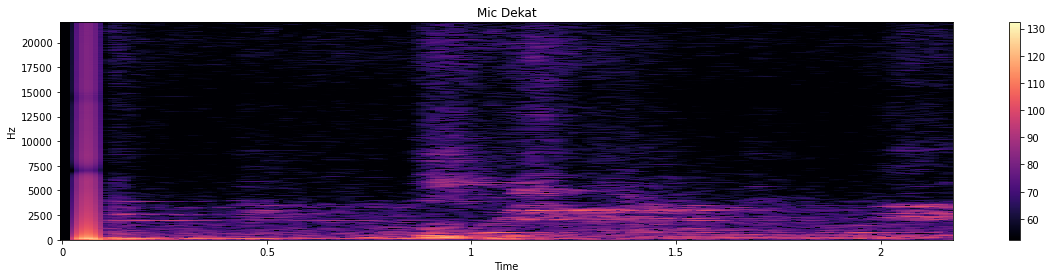

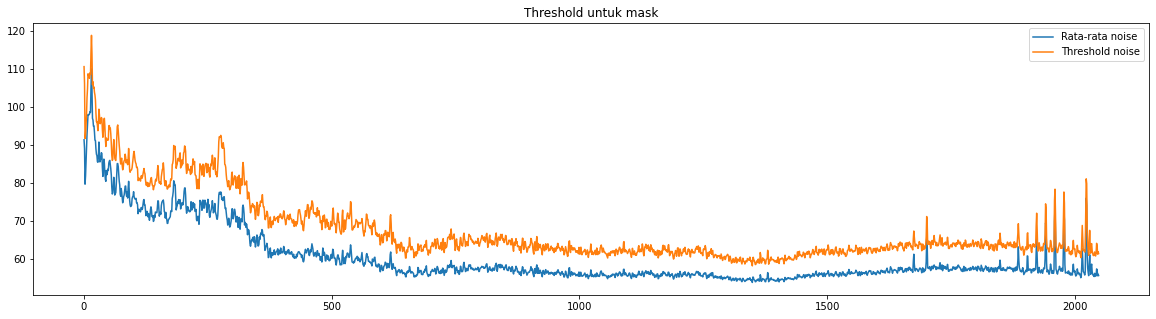

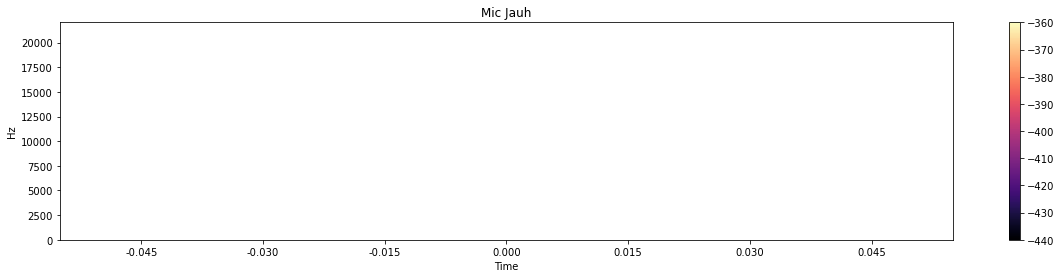

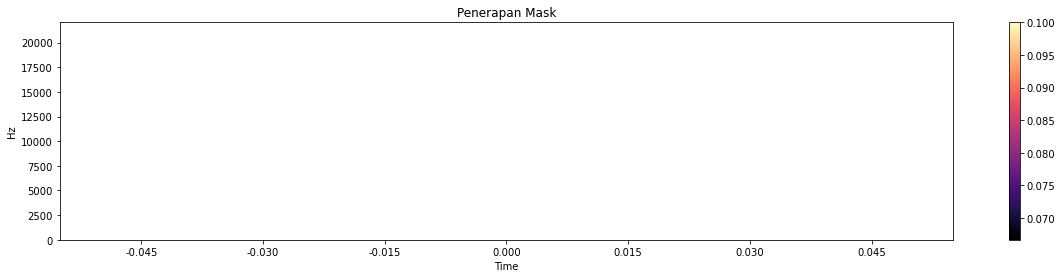

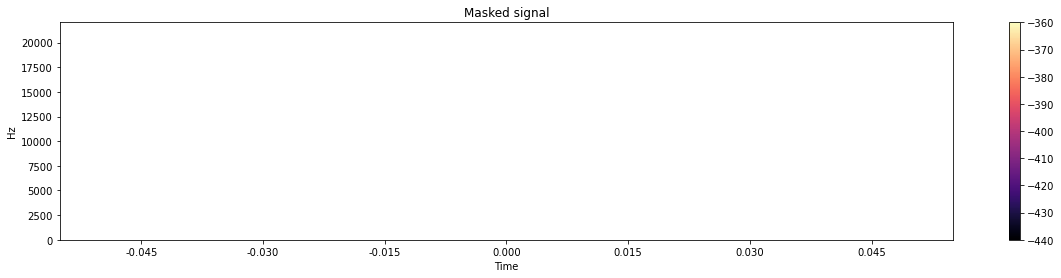

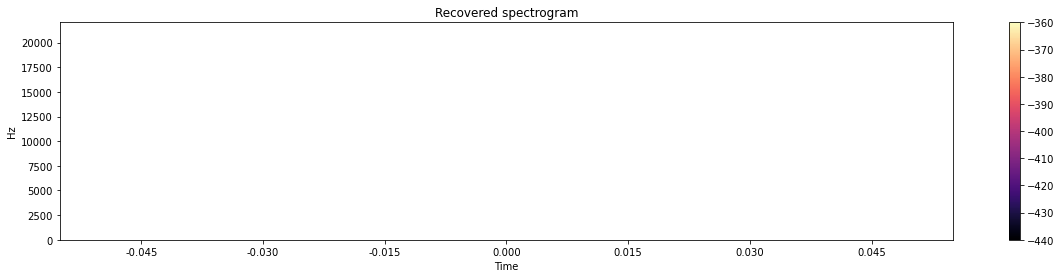

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:58: FutureWarning: Pass n_fft=4096, hop_length=512, win_length=4096 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MD_stft = librosa.stft(MD, n_fft, hop_length, win_length, window='hann')
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:70: FutureWarning: Pass n_fft=4096, hop_length=512, win_length=4096 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MJ_stft = librosa.stft(MJ, n_fft, hop_length, win_length, window='hann')
c:\Users\Lenovo\anaconda3\lib\site-packages\librosa\util\decorators.py:104: UserWarning: n_fft=4096 is too small for input signal of length=0
  return f(**kwargs)
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_25352/224768225.py:107: FutureWarning: Pass n_fft=4096, hop_length=512, win_length=4096 as keyword args. From version 0.10 passing these as positional arguments will result in an error

In [2]:
MJ_BG = r"output (2).wav"
MD_BG = r"Output.wav"

sr_MJ_BG, MJ_BG = read_audio(MJ_BG)
sr_noise, MD_BG = read_audio(MD_BG)

MJ_BG = MJ_BG.astype(float)
MD_BG = generate_noise_sample(MD_BG, 2)

output_BG = noise_red(MJ_BG, MD_BG, fft_size = 4096, iterations = 3)

wavfile.write("BG Penulisan.wav", 44100, output_BG.astype(np.int16))

In [3]:
MJ_objek = r"Aluminium MJ (6).wav"
MD_objek = r"Bambu MD (2.1).wav"

sr_MJ, MJ_objek = read_audio(MJ_objek)
sr_noise, MD_objek = read_audio(MD_objek)

MJ_objek = MJ_objek.astype(float)
MD_objek = generate_noise_sample(MD_objek, 2)

output_objek = noise_red(MJ_objek, MD_objek, fft_size = 4096, iterations = 3)

wavfile.write("Pvc 30cm MD-MJ.wav", 44100, output_objek.astype(np.int16))

FileNotFoundError: [Errno 2] No such file or directory: 'Aluminium MJ (6).wav'

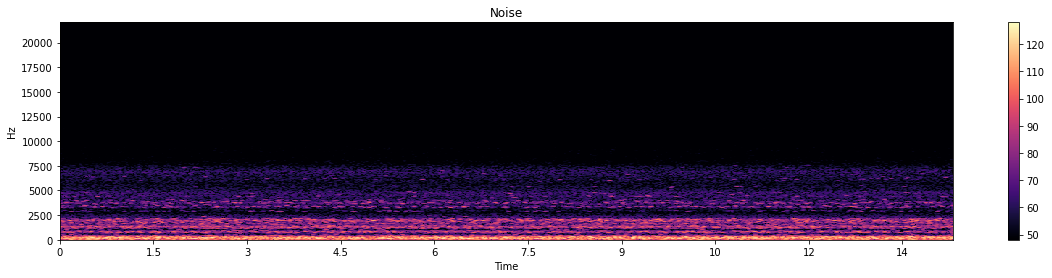

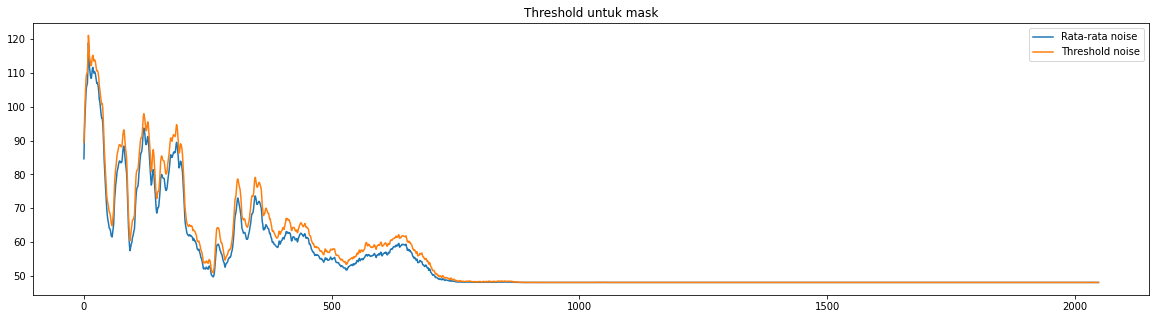

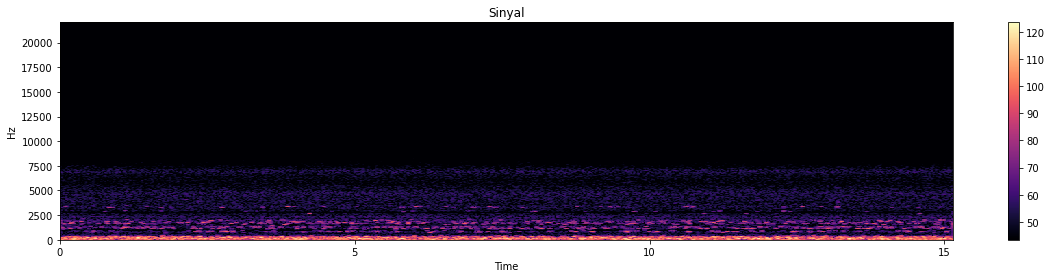

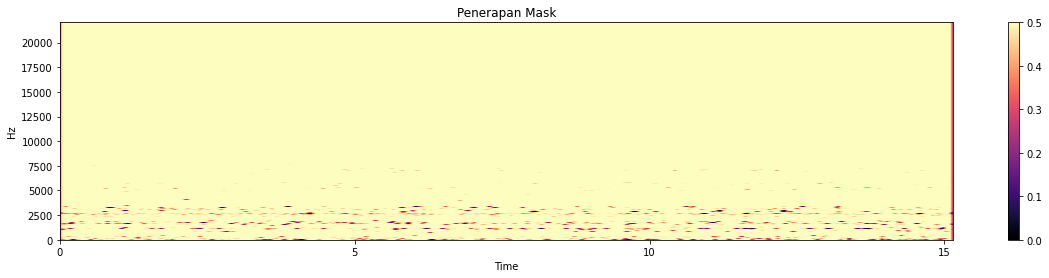

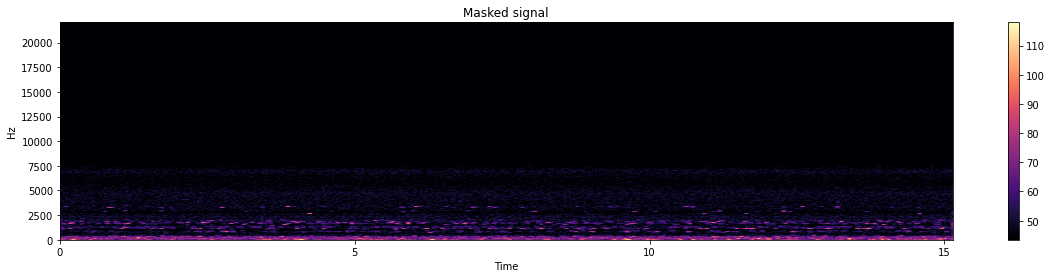

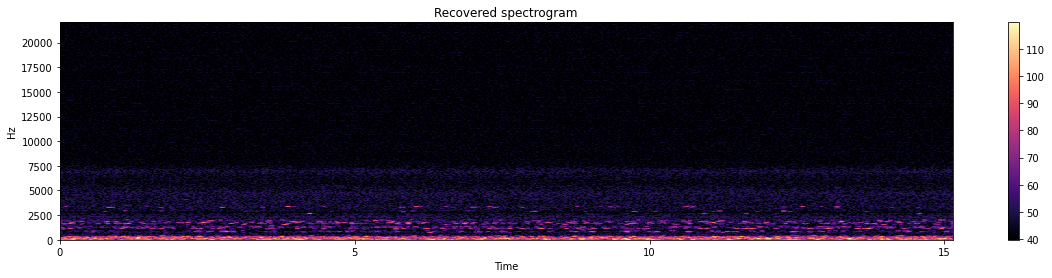

Text(0.5, 0, 'Time (s)')

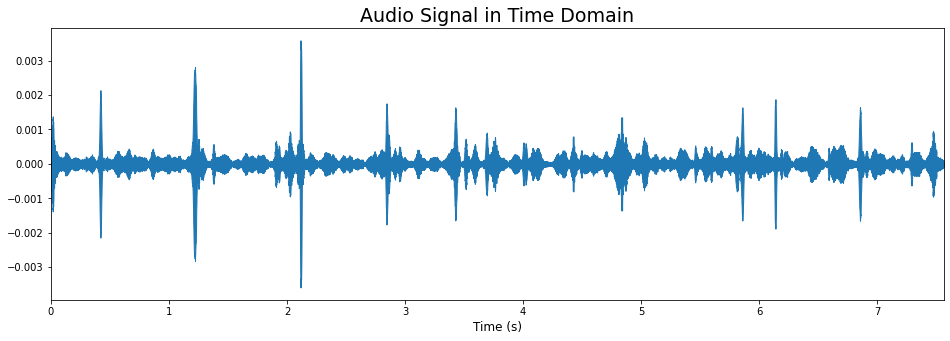

In [ ]:
# Masukkan file
file_objek = r"Bambu MJ (8.1).wav"
file_BG = r"BG MJ (2).wav"
sr_objek, objek = read_audio(file_objek)
sr_noise, BG = read_audio(file_BG)

objek = objek.astype(float)
noise = generate_noise_sample(BG, 20)

output_final = noise_red2(objek, noise, fft_size = 4096, iterations = 6)

AudioName = "Bambu Baru.wav"
wavfile.write(AudioName, 44100, output_final.astype(np.int16))

# Plot the audio signal in time
x, sr = librosa.load(AudioName)
plt.figure(figsize=(16, 5))
plt.title('Audio Signal in Time Domain',size=19)
librosa.display.waveplot(x, 44100)
plt.xlabel('Time (s)', size=12)
#plt.ylabel('Amplitude (dB)', size=12)

Text(0.5, 1.0, 'Frequency Analysis')

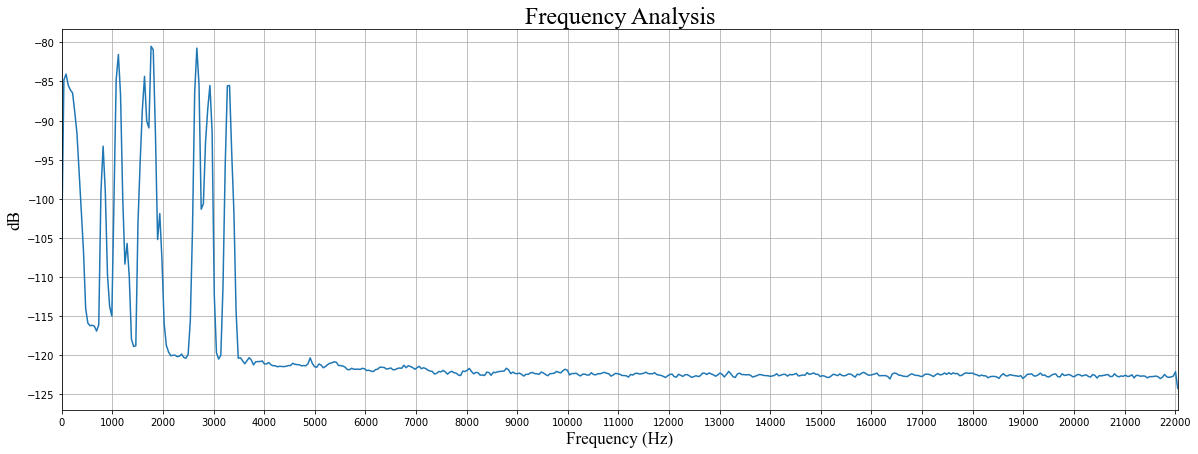

In [ ]:
AudioName = "Bambu Baru.wav" # Audio File
fs, data = wavfile.read(AudioName)
convertFromPSD = 10**(-72/20)
dB = data*convertFromPSD

fig, ax = plt.subplots(figsize=(20,7))
p = WelchPeriodogram(dB, NFFT=1024, sampling=fs)
plt.ylabel('dB', size=17, font="Times New Roman")
plt.xlim(0, 22050)
plt.xlabel('Frequency (Hz)', size=17, font="Times New Roman")
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.title('Frequency Analysis', size=24, font="Times New Roman")

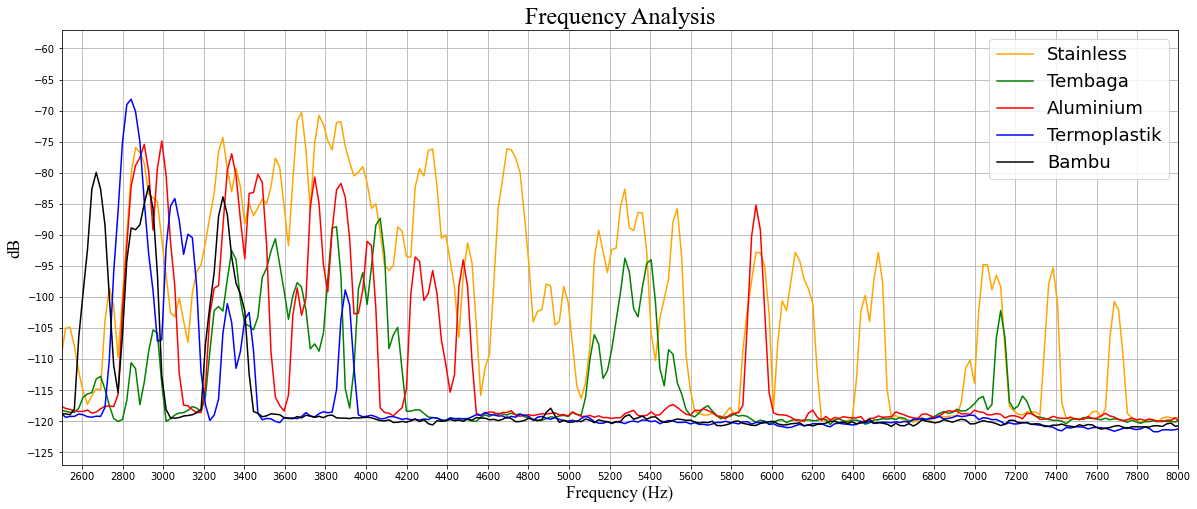

In [ ]:
AudioName = "Stainless Baru.wav" # Audio File
fs, data = wavfile.read(AudioName)
convertFromPSD = 10**(-77/20)
dB = data*convertFromPSD

AudioName2 = "Tembaga Baru.wav" # Audio File
fs2, data2 = wavfile.read(AudioName2)
convertFromPSD = 10**(-77/20)
dB2 = data2*convertFromPSD

AudioName3 = "Aluminium Baru.wav" # Audio File
fs3, data3 = wavfile.read(AudioName3)
convertFromPSD = 10**(-72/20)
dB3 = data3*convertFromPSD

AudioName4 = "Lem Baru.wav" # Audio File
fs4, data4 = wavfile.read(AudioName4)
convertFromPSD = 10**(-79/20)
dB4 = data4*convertFromPSD

AudioName5 = "Bambu Baru.wav" # Audio File
fs5, data5 = wavfile.read(AudioName5)
convertFromPSD = 10**(-70.5/20)
dB5 = data5*convertFromPSD

fig, ax = plt.subplots(figsize=(20,8))

sinyal1 = WelchPeriodogram(dB, NFFT=2048, sampling=fs, label="Stainless Steel", color="Orange")
sinyal2 = WelchPeriodogram(dB2, NFFT=2048, sampling=fs2, label="Tembaga", color="Green")
sinyal3 = WelchPeriodogram(dB3, NFFT=2048, sampling=fs3, label="Aluminium", color="Red")
sinyal4 = WelchPeriodogram(dB4, NFFT=2048, sampling=fs4, label="Termoplastik", color="Blue")
sinyal5 = WelchPeriodogram(dB5, NFFT=2048, sampling=fs5, label="Bambu", color="Black")

plt.ylabel('dB', size=17, font="Times New Roman")
plt.xlim(2500, 8000)
plt.xlabel('Frekuensi (Hz)', size=17, font="Times New Roman")
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.set_title('Analisis Frekuensi', size=24, font="Times New Roman")
ax.legend(fontsize=18)
plt.show()

In [ ]:
import IPython
from scipy.io import wavfile
import scipy.signal
import contextlib
import sys
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from datetime import timedelta as td
from spectrum import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

%matplotlib inline

#--------------------------------------------------Input File Background---------------------------------------------------
MD_BG = r"Bg md (2).wav" #Mic dekat (Background)
MJ_BG = r"Bg mj (3).wav" #Mic jauh (Background)
file_BG = r"Bg mj (3.1).wav" #Save name background

#--------------------------------------------------Input File Objek---------------------------------------------------
MD_objek = r"Pvc md.wav" #Mic dekat (objek)
MJ_objek = r"Pvc mj.wav" #Mic jauh (objek)
file_objek = r"Kayu mj (4.2).wav" #Save name objek

def get_parameters(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()
        pcm_data = wf.readframes(wf.getnframes())
        return num_channels, sample_width, sample_rate, type(pcm_data)
    
def read_audio(path):
    samprate_audio, audio = wavfile.read(path)
    num_channels, samp_width, samp_rate, type= get_parameters(path)
    if num_channels!=1:
        audio = audio[:,1]
    return samprate_audio, audio

def generate_noise_sample(noise, length):
    MD = noise[:sr_noise*length]
    MD = np.asarray(MD, dtype=float)
    return MD
  
def plot_spectrogram(signal, title):
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(signal, sr=44100, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_statistics(mean_noise, std_noise, noise_th):
    fig, ax = plt.subplots(figsize=(20,5))
    plt_mean, = ax.plot(mean_noise, label='Rata-rata noise')
    #plt_std, = ax.plot(std_noise, label='Std. power of noise')
    plt_std, = ax.plot(noise_th, label='Threshold noise')
    ax.set_title('Threshold untuk mask')
    ax.legend()
    plt.show()
    
def removeNoise(MJ, MD, n_grad_freq=2, n_grad_time=4, n_fft=2048, win_length=2048, hop_length=512,
                n_std_th=1.5, prop_decrease=0, verbose=False, visual=False):
    if verbose: start = time.time()
        
    # STFT pada MD
    MD_stft = librosa.stft(MD, n_fft, hop_length, win_length, window='hann')
    MD_abs = np.abs(MD_stft)
    MD_stft_db = librosa.core.amplitude_to_db(MD_abs, ref=1.0, amin=1e-20, top_db=80.0)
        
    # Hitung statistik pada MD
    mean_MD = np.mean(MD_stft_db, axis =1)
    std_MD = np.std(MD_stft_db, axis =1)
    th = mean_MD + (std_MD * n_std_th)
    # n_std_th: berapa banyak standar deviasi yang lebih keras dari rata-rata dB kebisingan
    #           (pada setiap tingkat frekuensi) yang dianggap sebagai sinyal
    if verbose: print('STFT pada MD:', td(seconds=time.time()-start)); start = time.time()
        
    # STFT pada MJ
    if verbose: start = time.time()
    MJ_stft = librosa.stft(MJ, n_fft, hop_length, win_length, window='hann')
    MJ_abs = np.abs(MJ_stft)
    MJ_stft_db = librosa.core.amplitude_to_db(MJ_abs, ref=1.0, amin=1e-20, top_db=80.0)
    if verbose: print('STFT pada MJ:',td(seconds=time.time()-start)); start = time.time()
        
    # Hitung nilai minimal untuk mask
    mask_gain_dB = np.min(MJ_stft_db)
    if verbose: print(noise_th, mask_gain_dB)
    
    # Buat smoothing filter untuk mask pada time dan frequency
    smoothing_filter = np.outer(np.concatenate([np.linspace(0,1, n_grad_freq + 1, endpoint=False),
                                                np.linspace(1,0, n_grad_freq + 2)])[1:-1],
                                np.concatenate([np.linspace(0,1, n_grad_time + 1, endpoint=False),
                                                np.linspace(1,0, n_grad_time + 2)])[1:-1])
    
    smoothing_filter = smoothing_filter/np.sum(smoothing_filter)
    
    # Hitung threshold untuk setiap frequency/time bin
    db_th = np.repeat(np.reshape(th, [1,len(mean_MD)]), np.shape(MJ_stft_db)[1], axis = 0).T
    
    # mask jika sinyal diatas threshold
    MJ_mask = MJ_stft_db<db_th
    if verbose: print('Masking:', td(seconds=time.time()-start)); start = time.time()
        
    # Operasi konvolusi mask dengan smoothing filter
    MJ_mask = scipy.signal.fftconvolve(MJ_mask, smoothing_filter,  mode='same')
    MJ_mask = MJ_mask*prop_decrease
    if verbose: print('Mask convolution:', td(seconds=time.time()-start)); start = time.time()
        
    # mask the signal
    MJ_stft_db_masked = MJ_stft_db *(1-MJ_mask) + np.ones(np.shape(mask_gain_dB))*mask_gain_dB*MJ_mask # mask real
    MJ_imag_masked = np.imag(MJ_stft)*(1-MJ_mask)
    MJ_amp = librosa.core.db_to_amplitude(MJ_stft_db_masked,ref=1.0)
    MJ_stft_amp = (MJ_amp * np.sign(MJ_stft)) + (1j * MJ_imag_masked)
    if verbose: print('Mask application:', td(seconds=time.time()-start)); start = time.time()
        
    # recover the signal
    recovered_signal = librosa.istft(MJ_stft_amp, hop_length, win_length)
    recovered_STFT = librosa.stft(recovered_signal, n_fft, hop_length, win_length, window='hann')
    recovered_abs = np.abs(recovered_STFT)
    recovered_spec = librosa.core.amplitude_to_db(recovered_abs, ref=1.0, amin=1e-20, top_db=80.0)
    if verbose: print('Signal recovery:', td(seconds=time.time()-start));
    if visual: plot_spectrogram(MD_stft_db, title='Noise')
    if visual: plot_statistics_and_filter(mean_noise, std_noise, noise_th, smoothing_filter)
    if visual: plot_spectrogram(MJ_stft_db, title='Signal')
    if visual: plot_spectrogram(MJ_mask, title='Mask applied')
    if visual: plot_spectrogram(MJ_stft_db_masked, title='Masked signal')
    if visual: plot_spectrogram(recovered_spec, title='Recovered spectrogram')
    return recovered_signal

def noise_red(MJ, MD, prop_decrease = 0.5, verbose = False, visual = False, fft_size = 4096, iterations = 2):
    output = removeNoise(MJ, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease,
                         n_std_th=1.0, verbose=False, visual=False)
    iterations = iterations - 1
    while(iterations!=0):
        output = removeNoise(output, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease, verbose=False, visual=False)
        iterations = iterations - 1
    return output

def noise_red2(MJ, MD, prop_decrease = 0.5, verbose = False, visual = False, fft_size = 4096, iterations = 6):
    output = removeNoise(MJ, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease,
                         n_std_th=0.5, verbose=False, visual=False)
    iterations = iterations - 1
    while(iterations!=0):
        output = removeNoise(output, MD, n_fft = fft_size, win_length = fft_size, prop_decrease = prop_decrease,
                             n_std_th=0.5, verbose=False, visual=False)
        iterations = iterations - 1
    return output

sr_MJ_BG, MJ_BG = read_audio(MJ_BG)
sr_noise, MD_BG = read_audio(MD_BG)

MJ_BG = MJ_BG.astype(float)
MD_BG = generate_noise_sample(MD_BG, 2)

output_BG = noise_red(MJ_BG, MD_BG, fft_size = 4096, iterations = 3)

sr_MJ, MJ_objek = read_audio(MJ_objek)
sr_noise, MD_objek = read_audio(MD_objek)

MJ_objek = MJ_objek.astype(float)
MD_objek = generate_noise_sample(MD_objek, 2)

output_objek = noise_red(MJ_objek, MD_objek, fft_size = 4096, iterations = 3)

sr_objek, objek = read_audio(file_objek)
sr_noise, BG = read_audio(file_BG)

objek = objek.astype(float)
noise = generate_noise_sample(BG, 2)

output_final = noise_red2(objek, noise, fft_size = 4096, iterations = 7)

#-----------------------------------------------------Plot audio-----------------------------------------------------------
FinalAudio = "Kayu 30 cm.wav" #Nama File
wavfile.write(FinalAudio, 44100, output_final.astype(np.int16)) #Save file di PC

# Plot audio dalam domain waktu
x, sr = librosa.load(FinalAudio)
plt.figure(figsize=(14, 5))
plt.title('Audio Signal in Time Domain',size=19)
librosa.display.waveplot(x, 44100)
plt.xlabel('Time (s)', size=12)
#plt.ylabel('Amplitude (dB)', size=12)

fs, data = wavfile.read(FinalAudio)
dB_scale = 10**(-93.5/20)
dB = data*dB_scale

fig, ax = plt.subplots(figsize=(20,7))
p = WelchPeriodogram(dB, NFFT=1024, sampling=fs)
plt.ylabel('dB', size=17, font="Times New Roman")
plt.xlim(0, 22050)
plt.xlabel('Frequency (Hz)', size=17, font="Times New Roman")
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.title('Frequency Analysis', size=24, font="Times New Roman")

FileNotFoundError: [Errno 2] No such file or directory: 'Bg md (2).wav'